# 한국어 트랜스포머 챗봇

In [1]:
import sys, subprocess
def _pip_install(pkg):
    try:
        __import__(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

_pip_install('sentencepiece')
_pip_install('pandas')
_pip_install('torch')
_pip_install('matplotlib')
print('환경 준비 완료')


환경 준비 완료


In [2]:
import os, re, urllib.request, random, math
import pandas as pd
import numpy as np
import sentencepiece as spm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("mps")
print('Device:', device)


Device: mps


## Step 1. 데이터 수집하기
공개된 한국어 챗봇 데이터셋인 **songys/Chatbot_data**의 CSV 파일을 다운로드


In [3]:
from pathlib import Path

ROOT = Path('~/work/transformer_chatbot').expanduser()
DATA_DIR = ROOT / 'data'
DATA_DIR.mkdir(parents=True, exist_ok=True)
csv_url = 'https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv'
csv_path = DATA_DIR / 'ChatbotData.csv'

if not csv_path.exists():
    print('Downloading ChatbotData.csv ...')
    urllib.request.urlretrieve(csv_url, csv_path.as_posix())
    print('Download complete:', csv_path)
else:
    print('Already exists:', csv_path)

print('DATA_DIR:', DATA_DIR)


Already exists: /Users/sunmoan/work/transformer_chatbot/data/ChatbotData.csv
DATA_DIR: /Users/sunmoan/work/transformer_chatbot/data


## Step 2. 데이터 전처리하기


In [4]:
def clean_ko(text: str) -> str:
    text = str(text)
    text = text.replace('\u200b', ' ').replace('\ufeff', ' ')
    text = text.replace('“','"').replace('”','"').replace('’',"'")
    text = re.sub(r"\s+", " ", text).strip()
    return text

df = pd.read_csv(csv_path)
assert set(['Q','A']).issubset(df.columns), 'CSV에 Q, A 컬럼이 없습니다.'

df['Q'] = df['Q'].map(clean_ko)
df['A'] = df['A'].map(clean_ko)
df = df.dropna(subset=['Q','A'])
df = df.drop_duplicates(subset=['Q','A']).reset_index(drop=True)

# 길이 필터는 선택. 과도하게 긴 샘플 제거
df = df[(df['Q'].str.len() >= 1) & (df['A'].str.len() >= 1)]
print('샘플 수:', len(df))
df.head()


샘플 수: 11750


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## Step 3. SentencePiece 사용하기

In [5]:
corpus_path = DATA_DIR / 'ko_chat_corpus.txt'
with open(corpus_path, 'w', encoding='utf-8') as f:
    for q, a in zip(df['Q'], df['A']):
        f.write(q + '\n')
        f.write(a + '\n')
print('코퍼스 경로:', corpus_path)

spm_prefix = (DATA_DIR / 'spm_ko_chatbot').as_posix()
vocab_size = 8000

model_path = DATA_DIR / 'spm_ko_chatbot.model'
if not model_path.exists():
    print('Training SentencePiece...')
    spm.SentencePieceTrainer.Train(
        input=corpus_path.as_posix(),
        model_prefix=spm_prefix,
        vocab_size=vocab_size,
        character_coverage=0.9995,
        model_type='bpe',
        pad_id=0,
        bos_id=1,
        eos_id=2,
        unk_id=3,
        input_sentence_size=2000000,
        shuffle_input_sentence=True
    )
    print('SentencePiece 학습 완료:', model_path)
else:
    print('SentencePiece 모델 이미 존재:', model_path)

sp = spm.SentencePieceProcessor()
sp.Load(model_path.as_posix())
PAD_ID = sp.pad_id()
BOS_ID = sp.bos_id()
EOS_ID = sp.eos_id()
try:
    VOCAB_SIZE = sp.get_piece_size()
except Exception:
    VOCAB_SIZE = sp.GetPieceSize()
print('Vocab size:', VOCAB_SIZE, '| PAD:', PAD_ID, 'BOS:', BOS_ID, 'EOS:', EOS_ID)

ex = '안녕하세요 만나서 반가워요'
print('예시 문장:', ex)
print('토큰:', sp.encode(ex, out_type=str))
print('인덱스:', sp.encode(ex, out_type=int))
print('디코딩:', sp.decode(sp.encode(ex, out_type=int)))


코퍼스 경로: /Users/sunmoan/work/transformer_chatbot/data/ko_chat_corpus.txt
SentencePiece 모델 이미 존재: /Users/sunmoan/work/transformer_chatbot/data/spm_ko_chatbot.model
Vocab size: 8000 | PAD: 0 BOS: 1 EOS: 2
예시 문장: 안녕하세요 만나서 반가워요
토큰: ['▁안녕하세요', '▁만나서', '▁반가워요']
인덱스: [4585, 1917, 6388]
디코딩: 안녕하세요 만나서 반가워요


## Step 4. 모델 구성하기
PyTorch의 `nn.Transformer`로 인코더-디코더 구조를 만듭니다. 임베딩, 위치인코딩, 출력층을 포함합니다.


In [6]:
class KoChatDataset(torch.utils.data.Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        return self.pairs[idx]

def make_collate_fn(sp, pad_id, bos_id, eos_id, max_src_len=40, max_tgt_len=40):
    def collate(batch):
        src_list, tgt_in_list, tgt_out_list = [], [], []
        for q, a in batch:
            src = [bos_id] + sp.encode(q, out_type=int) + [eos_id]
            tgt = [bos_id] + sp.encode(a, out_type=int) + [eos_id]
            src = src[:max_src_len]
            tgt = tgt[:max_tgt_len]
            tgt_in = tgt[:-1]
            tgt_out = tgt[1:]
            src_list.append(torch.tensor(src, dtype=torch.long))
            tgt_in_list.append(torch.tensor(tgt_in, dtype=torch.long))
            tgt_out_list.append(torch.tensor(tgt_out, dtype=torch.long))
        src_pad = pad_sequence(src_list, batch_first=True, padding_value=pad_id)
        tgt_in_pad = pad_sequence(tgt_in_list, batch_first=True, padding_value=pad_id)
        tgt_out_pad = pad_sequence(tgt_out_list, batch_first=True, padding_value=pad_id)
        return src_pad, tgt_in_pad, tgt_out_pad
    return collate

pairs = list(zip(df['Q'].tolist(), df['A'].tolist()))
dataset = KoChatDataset(pairs)
val_ratio = 0.1
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 64
MAX_SRC_LEN = 40
MAX_TGT_LEN = 40

collate_fn = make_collate_fn(sp, PAD_ID, BOS_ID, EOS_ID, MAX_SRC_LEN, MAX_TGT_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
len(train_loader), len(val_loader)


(166, 19)

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    mask = torch.triu(torch.ones(sz, sz, device=device), 1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask


class TransformerChatModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=2, dim_ff=512, dropout=0.1, pad_id=0):
        super().__init__()
        self.d_model = d_model
        self.pad_id = pad_id
        self.src_embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.tgt_embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        # Disable nested tensor fast path; MPS backend lacks the required ops.
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, enable_nested_tensor=False)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt_in):
        src_key_padding_mask = (src == self.pad_id)
        tgt_key_padding_mask = (tgt_in == self.pad_id)
        tgt_mask = generate_square_subsequent_mask(tgt_in.size(1))

        src_emb = self.pos_enc(self.src_embed(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_enc(self.tgt_embed(tgt_in) * math.sqrt(self.d_model))

        memory = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)
        out = self.decoder(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )
        logits = self.fc_out(out)
        return logits
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

def accuracy_function(y_pred, y_true, pad_id=0):
    preds = y_pred.argmax(dim=-1)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

D_MODEL = 256
NHEAD = 8
NUM_LAYERS = 2
DIM_FF = 512
DROPOUT = 0.1

model = TransformerChatModel(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_ff=DIM_FF,
    dropout=DROPOUT,
    pad_id=PAD_ID
).to(device)
print(model)

loss_function = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=1.0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))


TransformerChatModel(
  (src_embed): Embedding(8000, 256, padding_idx=0)
  (tgt_embed): Embedding(8000, 256, padding_idx=0)
  (pos_enc): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttent

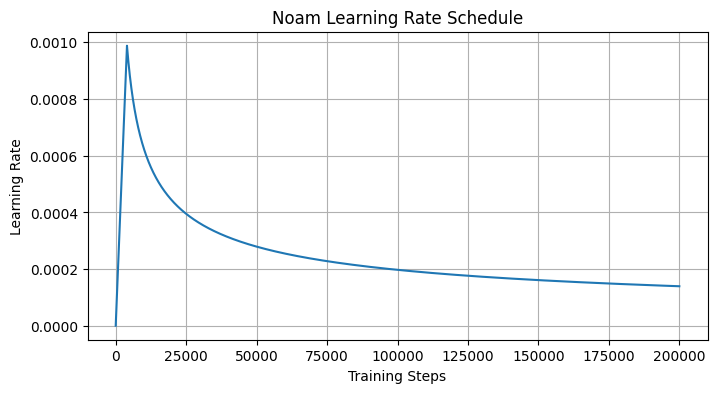

In [8]:
total_steps = 200000
steps = np.arange(1, total_steps + 1)
lrs = [get_lr_lambda(D_MODEL, 4000)(s) for s in steps]
plt.figure(figsize=(8,4))
plt.plot(steps, lrs)
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Noam Learning Rate Schedule')
plt.grid(True)
plt.show()


### 학습 루프
짧은 에폭으로 먼저 동작을 확인한 뒤 필요 시 늘리면 됩니다.


In [9]:
def train_one_epoch(model, loader, optimizer, scheduler, loss_fn):
    model.train()
    total_loss, total_acc, count = 0.0, 0.0, 0
    for step, (src, tgt_in, tgt_out) in enumerate(loader):
        src = src.to(device)
        tgt_in = tgt_in.to(device)
        tgt_out = tgt_out.to(device)

        optimizer.zero_grad()
        logits = model(src, tgt_in)
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        acc = accuracy_function(logits, tgt_out, pad_id=PAD_ID).item()
        total_loss += loss.item()
        total_acc += acc
        count += 1
        if step % 100 == 0:
            print(f"step {step:5d} | loss {loss.item():.4f} | acc {acc:.4f}")
    return total_loss / max(count, 1), total_acc / max(count, 1)

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, total_acc, count = 0.0, 0.0, 0
    with torch.no_grad():
        for src, tgt_in, tgt_out in loader:
            src = src.to(device)
            tgt_in = tgt_in.to(device)
            tgt_out = tgt_out.to(device)
            logits = model(src, tgt_in)
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            acc = accuracy_function(logits, tgt_out, pad_id=PAD_ID).item()
            total_loss += loss.item()
            total_acc += acc
            count += 1
    return total_loss / max(count,1), total_acc / max(count,1)

EPOCHS = 10
best_val = float('inf')
save_path = (DATA_DIR / 'transformer_ko_chatbot.pt').as_posix()

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scheduler, loss_function)
    val_loss, val_acc = evaluate(model, val_loader, loss_function)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save({'model_state_dict': model.state_dict(),
                    'vocab_size': VOCAB_SIZE,
                    'pad_id': PAD_ID,
                    'bos_id': BOS_ID,
                    'eos_id': EOS_ID,
                    'd_model': D_MODEL,
                    'nhead': NHEAD,
                    'num_layers': NUM_LAYERS,
                    'dim_ff': DIM_FF,
                    'dropout': DROPOUT}, save_path)
        print('모델 저장:', save_path)


/opt/homebrew/anaconda3/envs/test/lib/python3.14/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


step     0 | loss 9.2350 | acc 0.0000
step   100 | loss 7.5227 | acc 0.2646
Epoch 01 | train loss 8.0435 acc 0.1569 | val loss 6.7085 acc 0.2860
모델 저장: /Users/sunmoan/work/transformer_chatbot/data/transformer_ko_chatbot.pt
step     0 | loss 6.7196 | acc 0.2883
step   100 | loss 6.1193 | acc 0.2959
Epoch 02 | train loss 6.2352 acc 0.2889 | val loss 5.9424 acc 0.2864
모델 저장: /Users/sunmoan/work/transformer_chatbot/data/transformer_ko_chatbot.pt
step     0 | loss 5.8272 | acc 0.2826
step   100 | loss 5.8251 | acc 0.2793
Epoch 03 | train loss 5.7439 acc 0.2955 | val loss 5.6823 acc 0.2969
모델 저장: /Users/sunmoan/work/transformer_chatbot/data/transformer_ko_chatbot.pt
step     0 | loss 5.5901 | acc 0.2935
step   100 | loss 5.3917 | acc 0.3086
Epoch 04 | train loss 5.4701 acc 0.3071 | val loss 5.4895 acc 0.3066
모델 저장: /Users/sunmoan/work/transformer_chatbot/data/transformer_ko_chatbot.pt
step     0 | loss 5.1794 | acc 0.3218
step   100 | loss 4.8153 | acc 0.3606
Epoch 05 | train loss 5.1839 acc

## Step 5. 모델 평가하기
간단한 그리디 디코딩 함수로 입력 문장에 대한 챗봇 응답을 생성합니다.


In [10]:
@torch.no_grad()
def greedy_decode(model, sp, sentence: str, max_len=40):
    model.eval()
    def _tensor(x):
        return torch.tensor(x, dtype=torch.long, device=device).unsqueeze(0)

    src_ids = [BOS_ID] + sp.encode(clean_ko(sentence), out_type=int) + [EOS_ID]
    src = _tensor(src_ids)
    tgt = _tensor([BOS_ID])

    for _ in range(max_len):
        logits = model(src, tgt)
        next_token = logits[:, -1, :].argmax(dim=-1)
        next_id = next_token.item()
        if next_id == EOS_ID or next_id == PAD_ID:
            break
        tgt = torch.cat([tgt, next_token.unsqueeze(0)], dim=1)

    out_ids = tgt.squeeze(0).tolist()
    # BOS 제거
    out_ids = [i for i in out_ids if i not in (BOS_ID, EOS_ID, PAD_ID)]
    return sp.decode(out_ids)

def reply(text):
    print('입력:', text)
    print('출력:', greedy_decode(model, sp, text, max_len=MAX_TGT_LEN))

reply('안녕')
reply('오늘 기분이 안 좋아')
reply('배고픈데 뭐 먹을까')


입력: 안녕
출력: 제가 있잖아요.
입력: 오늘 기분이 안 좋아
출력: 저도 해보고 싶네요.
입력: 배고픈데 뭐 먹을까
출력: 맛있는 거 드세요.
